**Firstly grabbing our filtered dataset according to mappings**

In [1]:
# loading in our raw data
raw = spark.read.options(header=True,inferSchema=True).csv('airplane_raw')


# only selecting columns which we need
# also, we do not want flights which were cancelled (only valid flights or delays)
filtered_raw = raw.where(raw.Cancelled == 0).select('Year','Month','DayofMonth','Origin','Dest',\
                                                       'ArrDelay','DepDelay','ActualElapsedTime','Distance')
print(raw.printSchema())
#filtered_raw = filtered_raw.repartition(15)
# Got 116684126 records
#print(filtered_raw.count())

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Carr

In [2]:
# joining latitude and longitude values to the dataset
airport_metadata = spark.read.options(header=True,inferSchema=True).csv('./airplane_raw/metadata/airports.csv')
print(airport_metadata.printSchema())

filtered_raw = filtered_raw.join(airport_metadata.select('iata','lat','long')\
                             .withColumnRenamed('iata','Origin')\
                             .withColumnRenamed('lat','origin_lat')\
                             .withColumnRenamed('long','origin_long'), ['Origin'])

filtered_raw = filtered_raw.join(airport_metadata.select('iata','lat','long')\
                             .withColumnRenamed('iata','Dest')\
                             .withColumnRenamed('lat','dest_lat')\
                             .withColumnRenamed('long','dest_long'), ['Dest'])

print(filtered_raw.printSchema())

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)

None
root
 |-- Dest: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)

None


In [3]:
# loading or mapping from (year,month,day,airport) to id
airport_date_to_id_mapping = spark.read.parquet('./airport_date_to_id_mapping')
print(airport_date_to_id_mapping.printSchema())



# loading mapping from id to weather conditions
id_to_weather_mapping = spark.read.parquet('./id_to_weather_mapping')
print(id_to_weather_mapping.printSchema())

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- Airport: string (nullable = true)
 |-- id: long (nullable = true)

None
root
 |-- id: long (nullable = true)
 |-- ACSH: long (nullable = true)
 |-- WSFM: long (nullable = true)
 |-- WSFG: long (nullable = true)
 |-- SNOW: long (nullable = true)
 |-- TMAX: long (nullable = true)
 |-- SNWD: long (nullable = true)
 |-- PRCP: long (nullable = true)
 |-- AWND: long (nullable = true)
 |-- ACMH: long (nullable = true)
 |-- ACMC: long (nullable = true)
 |-- TMIN: long (nullable = true)

None


In [4]:
# dropping columns in the mapping which we do not need

final_weather_mapping = id_to_weather_mapping.select('id','PRCP','TMAX','TMIN','AWND')\
                                             .where(\
                                             (id_to_weather_mapping.PRCP!=-9999) &     \
                                             (id_to_weather_mapping.TMAX!=-9999) & \
                                             (id_to_weather_mapping.TMIN!=-9999) & \
                                             (id_to_weather_mapping.AWND!=-9999) \
                                             )
print(final_weather_mapping.count())



1336772


In [5]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

# mapping location and day,time to ids in the raw df
filtered_raw = filtered_raw.join(airport_date_to_id_mapping.withColumnRenamed('Airport','Origin').withColumnRenamed('id','origin_id'), \
                                ['Year','Month','DayofMonth','Origin'])
filtered_raw = filtered_raw.join(airport_date_to_id_mapping.withColumnRenamed('Airport','Dest').withColumnRenamed('id','dest_id'), \
                                ['Year','Month','DayofMonth','Dest'])

# adding a dayOfYear column
@F.udf(returnType = T.StringType())
def date_string(year,month,day):
    return year+'-'+month+'-'+day

# 12-2 is winter =0, 3-5 is spring=1, 6-8 is summer=2, 9-11 is fall=3
@F.udf(returnType = T.IntegerType())
def map_month_to_season(month):
    if month in {12,1,2}:
        return 0
    elif month in {3,4,5}:
        return 1
    elif month in {6,7,8}:
        return 2
    else:
        return 3


# dropping the year, month, dayofMonth, Origin,and Dest columns, since we have their unique ids
#filtered_raw = filtered_raw.withColumn('Date',F.concat_ws("-",filtered_raw.Year,filtered_raw.Month,filtered_raw.DayofMonth).cast("date"))
#filtered_raw = filtered_raw.withColumn('Date', F.dayofyear(filtered_raw.Date)).withColumnRenamed('Date','DayOfYear')
filtered_raw = filtered_raw.withColumn('Season',map_month_to_season(filtered_raw.Month))
filtered_raw = filtered_raw.drop('Year','Month','DayofMonth','Origin','Dest')
print(filtered_raw.printSchema())
print(filtered_raw.take(1))

root
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- origin_id: long (nullable = true)
 |-- dest_id: long (nullable = true)
 |-- Season: integer (nullable = true)

None
[Row(ArrDelay='16', DepDelay='0', ActualElapsedTime='93', Distance='282', origin_lat=40.69249722, origin_long=-74.16866056, dest_lat=42.94052472, dest_long=-78.73216667, origin_id=85899346091, dest_id=146028888418, Season=0)]


In [6]:
from math import isnan
# checking exactly how many records with weather that we have

# below collects map of (id -> [Weather conditions])
collect_weather = final_weather_mapping.rdd.map(lambda x: (x['id'],(x['PRCP'],x['TMAX'],x['TMIN'],x['AWND']))).collectAsMap()

collect_weather_broadcast = sc.broadcast(collect_weather)

# basically just grabbing records which are valid
def test_good_records(record):
    if record['ArrDelay'] == 'NA':
        return False
    elif record['DepDelay'] == 'NA':
        return False
    elif record['ActualElapsedTime'] == 'NA':
        return False
    elif record['Distance']=='NA':
        return False
    elif isnan(record['origin_lat']):
        return False
    elif isnan(record['origin_long']):
        return False
    elif isnan(record['dest_lat']):
        return False
    elif isnan(record['dest_long']):
        return False
    elif record['Season']==None:
        return False
    return True


filtered_raw = \
                filtered_raw.rdd\
                             .filter(test_good_records)\
                             .filter(lambda x: x['origin_id'] in collect_weather_broadcast.value \
                             and x['dest_id'] in collect_weather_broadcast.value).toDF()

#print(filtered_raw.where(filtered_raw.ArrDelay == 'NA').count())
#print(filtered_raw.where(filtered_raw.ActualElapsedTime == 'NA').count())
# 95830696
#print(filtered_raw.count())
# turning string columns into ints, so we can run BFR

filtered_raw = filtered_raw\
                           .withColumn('ArrDelay',filtered_raw.ArrDelay.cast('int'))\
                           .withColumn('DepDelay',filtered_raw.DepDelay.cast('int'))\
                           .withColumn('ActualElapsedTime',filtered_raw.ActualElapsedTime.cast('int'))\
                           .withColumn('Distance',filtered_raw.Distance.cast('int'))



In [7]:
# need to grab mean and std for each column so that we can normalize the df and apply clustering


joined = filtered_raw.join(final_weather_mapping.withColumnRenamed('id','origin_id'),'origin_id')\
                     .withColumnRenamed('PRCP','origin_prcp')\
                     .withColumnRenamed('TMAX','origin_tmax')\
                     .withColumnRenamed('TMIN','origin_tmin')\
                     .withColumnRenamed('AWND','origin_awnd')\
                     .join(final_weather_mapping.withColumnRenamed('id','dest_id'),'dest_id')\
                     .withColumnRenamed('PRCP','dest_prcp')\
                     .withColumnRenamed('TMAX','dest_tmax')\
                     .withColumnRenamed('TMIN','dest_tmin')\
                     .withColumnRenamed('AWND','dest_awnd')\
                     .drop('dest_id','origin_id')

columns = joined.columns
#print(joined.printSchema())

# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))

# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))

# lets write this data to parquet, just because
#joined.write.parquet('./FINAL_processed_data')


Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857405534, origin_long_mean=-92.27161607308402, dest_lat_mean=37.099157241985075, dest_long_mean=-92.26712071709842, Season_mean=1.4983448205364176, origin_prcp_mean=25.696228836739326, origin_tmax_mean=205.3709193033514, origin_tmin_mean=94.5765910747429, origin_awnd_mean=38.636158741871185, dest_prcp_mean=25.612486723460716, dest_tmax_mean=205.36587148443542, dest_tmin_mean=94.56188964755093, dest_awnd_mean=38.63819560488218, ArrDelay_stddev=30.939682127010062, DepDelay_stddev=28.437824166810316, ActualElapsedTime_stddev=70.31234179026455, Distance_stddev=569.0274209367313, origin_lat_stddev=5.599107569908229, origin_long_stddev=16.703784257869227, dest_lat_stddev=5.59970726731377, dest_long_stddev=16.697214735116198, Season_stddev=1.1130543679507285, origin_prcp_stddev=83.8530474281069, origin_tmax_stddev=105.31647

In [8]:
# bfr loop
from BFR_Logic import BFR
from math import sqrt
from pyspark.sql import Row
import numpy as np


# adding in weather data based on id
def add_weather(row):
    origin_weather = collect_weather_broadcast.value[row['origin_id']]
    dest_weather = collect_weather_broadcast.value[row['dest_id']]
    updated_row = row.asDict()
    updated_row['origin_prcp'] = origin_weather[0]
    updated_row['origin_tmax'] = origin_weather[1]
    updated_row['origin_tmin'] = origin_weather[2]
    updated_row['origin_awnd'] = origin_weather[3]
    
    updated_row['dest_prcp'] = dest_weather[0]
    updated_row['dest_tmax'] = dest_weather[1]
    updated_row['dest_tmin'] = dest_weather[2]
    updated_row['dest_awnd'] = dest_weather[3]
    
    del(updated_row['origin_id'])
    del(updated_row['dest_id'])
    
    return Row(**updated_row)

def map_row_to_list(row):
    return (\
            row['CRSDepTime'],\
            row['ArrDelay'],\
            row['DepDelay'],\
            row['ActualElapsedTime'],\
            row['Distance'],\
            row['origin_lat'],\
            row['origin_long'],\
            row['dest_lat'],\
            row['dest_long'],\
            row['DayOfYear'],\
            row['origin_prcp']\
           )

# for cure we only choose the distance to the closest representative to x
def cure_squared_error(clusters, x):
    vals = []
    for val in x:
        vals.append(val)
    vals = np.array(vals)
    distance = None
    for cluster in clusters:       
        for representative in cluster:
            dist = np.linalg.norm(representative-vals)
            if distance is None or dist < distance:
                distance=dist
    return distance ** 2
    
# num features
num_features = len(joined.columns)

print(joined.printSchema())

# num_clusters
for num_reps in range(4,8):
    for season in range(5):
        if season in {0,1,2,3} and num_reps in {4}:
            continue
        # season == 4 means that we DO NOT FILTER SEASON (we take everything)
        errors = np.zeros(7)
        for k in range(3,10):
            fraction = 0.2
            # getting clusters as a list of lists of representatives
            if season != 4:
                clusters = spark.read\
                                .parquet('./CURE_Clusters/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))\
                                .toPandas().to_numpy()
            else:
                clusters = spark.read\
                                .parquet('./CURE_Clusters/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))\
                                .toPandas().to_numpy()
            #print(clusters)
            if season!=4:
                final_dat = joined.where(joined.Season == season).drop('Season')
            else:
                final_dat = joined.drop('Season')

            error = final_dat.rdd.map(lambda x: cure_squared_error(clusters,x)).reduce(lambda x,y: x+y)

            errors[k-3]=error
            print('Season = '+str(season)+', K = '+str(k)+', num_reps= ' +str(num_reps) + ' ,Error = '+str(errors[k-3]))
        
        # writing errors to disk
        spark_errors = [(k+3,error.item()) for k,error in enumerate(errors)]
        if season !=4:
            sc.parallelize(spark_errors).toDF(['k','error']).coalesce(1).write.option('header',True)\
                                        .csv('./CURE_Errors/season='+str(season)+'_num_reps='+str(num_reps))
        else:
            sc.parallelize(spark_errors).toDF(['k','error']).coalesce(1).write.option('header',True)\
                                        .csv('./CURE_Errors/season=EVERYTHING'+'_num_reps='+str(num_reps))
    
   


root
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- Season: long (nullable = true)
 |-- origin_prcp: double (nullable = true)
 |-- origin_tmax: double (nullable = true)
 |-- origin_tmin: double (nullable = true)
 |-- origin_awnd: double (nullable = true)
 |-- dest_prcp: double (nullable = true)
 |-- dest_tmax: double (nullable = true)
 |-- dest_tmin: double (nullable = true)
 |-- dest_awnd: double (nullable = true)

None
Season = 4, K = 3, num_reps= 4 ,Error = 2237978385.7843757
Season = 4, K = 4, num_reps= 4 ,Error = 1615739978.7289624
Season = 4, K = 5, num_reps= 4 ,Error = 1855251355.4676845
Season = 4, K = 6, num_reps= 4 ,Error = 1408965576.151181
Season = 4, K = 7, num_reps= 4 ,Error = 1364371

In [9]:
def obtain_errors(season):
    errors = spark.read.csv('./BFR_Errors/season='+str(season),header=True,inferSchema=True)
    fin = errors.orderBy('k').select('error').toPandas().to_numpy()
    print(fin)
    return fin


[[3.25377047e+08]
 [3.05973663e+08]
 [3.07963101e+08]
 [2.63884988e+08]
 [2.63390068e+08]
 [2.17269815e+08]
 [2.45815661e+08]]


Text(0.5, 1.0, 'BFR: Season=0')

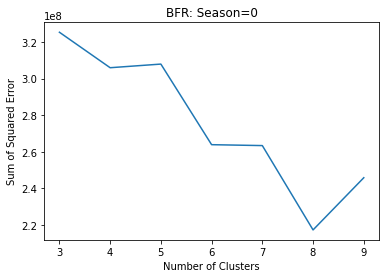

In [10]:
import matplotlib.pyplot as plt
# elbow plot
plt.plot([i for i in range(3,10)],obtain_errors(0))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.title("BFR: Season=0")